### Import

In [1]:
import pandas as pd
import numpy as np
import math
import csv
import re

from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation

from itertools import cycle

from matplotlib import pyplot as plt
%matplotlib inline

### Parametere

In [2]:
n_clusters=5

#type='Interesse' 
type='Kompetanse'

cat = ['IM', 'ITST', 'BST', 'Tverrfaglige kompetanser'] # Kategorier som fargelegges i komponent-plot
colors = ['b', 'y', 'r', 'g']                           # Fargene de får

### Funksjoner

In [3]:
fsize = 10

# Manuell justering av navnposisjoner Interesse

if type == 'Interesse':
    lpos = {'Krogvig': {'h': 'left', 'v': 'top'},
        'Aanonsen': {'h': 'left', 'v': 'top'},
        'Reidulff': {'h': 'right', 'v': 'top'},
        'Glaeserud': {'h': 'left', 'v': 'bottom'},
        'Nygaard': {'h': 'right', 'v': 'bottom'},
        'Lohne': {'h': 'right', 'v': 'bottom'},
        'Axelsen': {'h': 'right', 'v': 'bottom'},
        'Overrein': {'h': 'left', 'v': 'bottom'},
        'Tveit': {'h': 'right', 'v': 'bottom'},
        'Mortensen': {'h': 'left', 'v': 'top'},
        'Ehrndal': {'h': 'left', 'v': 'top'},
        'Berisha': {'h': 'center', 'v': 'bottom'},
        'Hermansen': {'h': 'left', 'v': 'bottom'},
        'Holte': {'h': 'left', 'v': 'center'},
        'Alnes': {'h': 'right', 'v': 'center'},
        'Viklander': {'h': 'right', 'v': 'top'},
        'Angset': {'h': 'left', 'v': 'top'},
        'Sandstrom': {'h': 'right', 'v': 'top'},
        'Thylin': {'h': 'right', 'v': 'bottom'},
        'Kragerud': {'h': 'left', 'v': 'bottom'},
        'Elstad': {'h': 'right', 'v': 'bottom'},
        'Haavik': {'h': 'right', 'v': 'bottom'},
        'Jahren': {'h': 'center', 'v': 'top'},
        'Kristensen': {'h': 'left', 'v': 'bottom'},
        'Strand': {'h': 'left', 'v': 'bottom'},
        'Thorne': {'h': 'left', 'v': 'center'},
         }

# Manuell justering av navnposisjoner Kompetanse
if type == 'Kompetanse':
    lpos = {'Krogvig': {'h': 'center', 'v': 'top'},
        'Aanonsen': {'h': 'left', 'v': 'top'},
        'Reidulff': {'h': 'right', 'v': 'top'},
        'Glaeserud': {'h': 'right', 'v': 'top'},
        'Nygaard': {'h': 'right', 'v': 'top'},
        'Lohne': {'h': 'right', 'v': 'bottom'},
        'Axelsen': {'h': 'left', 'v': 'top'},
        'Overrein': {'h': 'left', 'v': 'bottom'},
        'Tveit': {'h': 'right', 'v': 'top'},
        'Mortensen': {'h': 'right', 'v': 'top'},
        'Ehrndal': {'h': 'left', 'v': 'top'},
        'Berisha': {'h': 'right', 'v': 'top'},
        'Hermansen': {'h': 'left', 'v': 'bottom'},
        'Holte': {'h': 'left', 'v': 'top'},
        'Alnes': {'h': 'right', 'v': 'top'},
        'Viklander': {'h': 'center', 'v': 'bottom'},
        'Angset': {'h': 'right', 'v': 'bottom'},
        'Sandstrom': {'h': 'left', 'v': 'bottom'},
        'Thylin': {'h': 'left', 'v': 'bottom'},
        'Kragerud': {'h': 'left', 'v': 'bottom'},
        'Elstad': {'h': 'right', 'v': 'bottom'},
        'Haavik': {'h': 'right', 'v': 'bottom'},
        'Jahren': {'h': 'right', 'v': 'bottom'},
        'Kristensen': {'h': 'right', 'v': 'bottom'},
        'Strand': {'h': 'left', 'v': 'top'},
        'Thorne': {'h': 'left', 'v': 'bottom'},
        'Holmestad': {'h': 'center', 'v': 'top'},
        'Jorgensen': {'h': 'left', 'v': 'bottom'},
        'Paulsen': {'h': 'left', 'v': 'top'},
        'Fladmark': {'h': 'left', 'v': 'bottom'},
        'Lindberg': {'h': 'left', 'v': 'bottom'},
        'Klemsdal': {'h': 'center', 'v': 'top'},
        'Havro': {'h': 'right', 'v': 'top'},
        'Oysaed': {'h': 'center', 'v': 'bottom'},
         }

def group_variables(df, cats):
    
    # Lager nytt datasett med grupperte variabler
    
    ucats = set([])
    col2cat = {}
    subcat2cat = {}
    
    # Hent kompetansekategoriseringen og lagre i col2cat og ucats
    with open('Kategorier kompetanse og interesser.csv', 'r') as f:
        reader = csv.reader(f, delimiter=';')
        next(reader, None)
        for row in reader:
            col2cat[row[0]] = {'Kategori': row[1], 'Underkategori': row[2]}
            subcat2cat[row[2]] = row[1]
            ucats.add(row[2])
    
    # Lag nytt datasett med variabler som er snittet i hver underkategori
    dfc = df.reset_index()[['Navn', 'Team']]
    for ucat in ucats:
        col_subset = np.matrix(df[[col for col in df.columns if col2cat[col]['Underkategori'] == ucat]])
        dfc_add = pd.DataFrame(col_subset.sum(1)/col_subset.shape[1], columns=[ucat])
        if not any([math.isnan(a) for a in dfc_add[ucat]]):
            dfc = pd.concat([dfc, dfc_add], axis=1)
        
    dfc.set_index(['Navn','Team'],inplace=True)
        
    return dfc, subcat2cat

def do_pca(df):
    
    # Utfører selve PCAen
    
    pca = PCA(n_components=2)
    dfs = preprocessing.scale(ndf,with_std=False)
    pca.fit(dfs)
    transformed_df = pca.transform(dfs)
    newdf = pd.concat([df.reset_index()[['Navn', 'Team']], pd.DataFrame(transformed_df)], axis=1)
    components = pd.concat([df.transpose().reset_index()['index'], pd.DataFrame({'1':pca.components_[0]}), pd.DataFrame({'2':pca.components_[1]})], axis=1).set_index('index')
    return newdf, components

def flip_pca(df, components, flips=[]):
    
    # Endre fortegn på en av aksene dersom det blir finere
    
    if 'flip x' in flips: 
        df[0] *= -1
        components['1'] *= -1
        
    if 'flip y' in flips: 
        df[1] *= -1
        components['2'] *= -1
        
    return df, components
        

def plot_pca(df, lpos):
    
    # Lag scatterplot
    
    ms = 80
    ax = df[df['Team']=='IM'].plot(kind='scatter', x=0, y=1, s=ms, color='b', label='IM', figsize=(fsize+2,fsize+2))
    df[df['Team']=='BST' ].plot(kind='scatter', x=0, y=1, s=ms, color='r', label='BST', ax=ax)
    df[df['Team']=='ITST'].plot(kind='scatter', x=0, y=1, s=ms, color='y', label='ITST', ax=ax)


    for navn, team, x, y in df.values:
        shortname = re.match('([A-Za-z]+)\,?', navn).group(1)
        
        if shortname in lpos:
            horz = lpos[shortname]['h']
            vert = lpos[shortname]['v']
        elif team == 'IM':
            horz = 'right'
            vert = 'top'
        else:
            horz = 'left'
            vert = 'top'
            
        if vert == 'top': vs = -7
        if vert == 'bottom': vs = 7
        
        plt.annotate(shortname, xy=(x, y), size=15, textcoords = 'offset points', xytext = (0,vs), horizontalalignment = horz, verticalalignment = vert)
    
    plt.title('%skartet' % type, size=20)
    plt.xlabel('%s x-dimensjon' % type, size=18)
    plt.ylabel('%s y-dimensjon' % type, size=18)
    pass
    
def plot_cluster(newdf, cluster_df, lpos):
    plt.figure(figsize=(fsize+2,fsize+2))
    
    ms = 80
    ax = newdf[newdf['Team']=='IM'].plot(kind='scatter', x=0, y=1, s=ms, color='b', label='IM', figsize=(fsize+2,fsize+2))
    newdf[newdf['Team']=='BST' ].plot(kind='scatter', x=0, y=1, s=ms, color='r', label='BST', ax=ax)
    newdf[newdf['Team']=='ITST'].plot(kind='scatter', x=0, y=1, s=ms, color='y', label='ITST', ax=ax)
    
    ccolors = cycle('rgcmykb')
    for k, col in zip(range(n_clusters_), ccolors):
        class_members = labels == k
        cluster_center = X[cluster_centers_indices[k]]
        plt.plot(X[class_members, 0], X[class_members, 1], col + '.', zorder=0)
        plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=14, zorder=0)
        for x in X[class_members]:
            plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col, linewidth=2.0, zorder=0)
    
    plt.title('%skartet med gjenger' % type, size=20)
    
    cluster_df = pd.concat([df.reset_index()[['Navn', 'Team']], cluster_df], axis=1, ignore_index=True)
    cluster_df.columns=['Navn','Team',0,1]

    for navn, team, x, y in newdf.values:
        shortname = re.match('([A-Za-z]+)\,?', navn).group(1)
          
        if shortname in lpos:
            horz = lpos[shortname]['h']
            vert = lpos[shortname]['v']
        elif team == 'IM':
            horz = 'right'
            vert = 'top'
        else:
            horz = 'left'
            vert = 'top'
                
        if vert == 'top': vs = -7
        if vert == 'bottom': vs = 7
            
        plt.annotate(shortname, xy=(x, y), size=15, textcoords = 'offset points', xytext = (0,vs), horizontalalignment = horz, verticalalignment = vert)
        
    #plt.xticks(())
    #plt.yticks(())
    plt.xlabel('%s x-dimensjon' % type, size=18)
    plt.ylabel('%s y-dimensjon' % type, size=18)

    pass
    

def explain_axis(components, cat, subcat2cat, i):

    # Vis komponentforklaring for komponent i = 1, 2
    
    N = len(components[str(i)])
    amp = max(abs(components[str(i)]))
    
    
    values = components[str(i)].order()
    names = [a for a in values.index]
    names_2 = []
    
    fig, ax = plt.subplots(figsize=(fsize,fsize))
    
    ind = range(N)
    width = 0.5
    margin = 0.02
    
    rects = []
    for k,c in enumerate(cat):
        cind = [q for q in xrange(N) if subcat2cat[names[q]] == c]
        rects.append(ax.barh([ind[j] for j in cind], [values[j] for j in cind], width, color=colors[k]))
        names_2 += [names[j] for j in cind]
    
    # Text labels
    j = 0
    # For hvert sett av rektangler
    for rect in rects:
        # For hver rektangel
        for r in rect:
            
            if r.get_x() < 0:
                x = r.get_x() - margin
                px = x
                ha = 'right'
            else:
                x = r.get_width() + margin
                px = (r.get_x() - margin)
                ha = 'right'
                
            y = r.get_y() + width/2.
            
            s = names_2[j] + ' (%.2f)' % x
            
            ax.text(px, y, s, ha=ha, va='center',size=16)
            j += 1
        
    ax.set_xbound(-1.7*amp,1.7*amp)
    ax.set_ybound(-1,N)
    
    ax.axis('off')
    
    #if type == 'Kompetanse': ax.legend(cat[:3] + ['Tverrfaglig'], bbox_to_anchor=(0.1, 0.97), loc=2, prop={'size':18})
    #if type == 'Interesse': ax.legend(cat[:3], bbox_to_anchor=(0.2, 0.97), loc=2, prop={'size':18})
            
    pass

def plot_transformed_point(ndf, cat, type):
    
    
    cluster_idx = 2
    namelist = [tuple([a for a in ndf.reset_index().iloc[i][['Navn','Team']].values]) for i, l in enumerate(labels) if l==cluster_idx]
    
    for n in namelist: print n

    gruppenavn = 'IM-geeks'
              
    N = ndf.shape[1]
    
    data = ndf.loc[namelist].mean(axis=0)
    
    if type == 'Kompetanse': amp = 5
    if type == 'Interesse': amp = 3

    values = [v for v in data]
    
    names = [n for n in data.index]
    names_order = []
    
    fig, ax = plt.subplots(figsize=(fsize+4,fsize))
    
    width = 0.7      # the width of the bars
    ind = [x+.5 for x in xrange(N)]  # the x locations for the groups
        
    rects = []
    M = 0
    for k,c in enumerate(cat):
        
        cind = [q for q in range(N) if subcat2cat[names[q]] == c]
        cval = [values[j] for j in cind]
        cname = [names[j] for j in cind]
        
        dM = len(cind)
        tind = [x+.5 for x in xrange(M,M+dM)]
        M += dM
        
        #rects.append(ax.barh([ind[j] for j in cind], [values[j] for j in cind], width, color=colors[k]))
        rects.append(ax.bar(tind, cval, width, color=colors[k], align='center'))
        names_order += cname


    #rects1 = ax.bar(ind, values, width, color='r', align='center')
    
    # add some text for labels, title and axes ticks
    plt.ylabel('Gjennomsnittsrating', fontsize=18)
    ax.set_title('%sprofil %s' % (type, gruppenavn), fontsize=20)
    plt.yticks(xrange(amp+1), fontsize=16)
    plt.xticks(ind, fontsize=16)
    ax.set_xticklabels( names_order, rotation=30, ha='right')
    
    ax.set_xbound(0,N)
    ax.set_ybound(0,1.05*amp)
    
    #if type == 'Kompetanse': ax.legend(cat[:3] + ['Tverrfaglig'], bbox_to_anchor=(1.02, 0.98), loc=2, prop={'size':18})
    #if type == 'Interesse': ax.legend(cat[:3], bbox_to_anchor=(1.02, 0.98), loc=2, prop={'size':18})
        
    for a in xrange(amp):
        plt.axhline(y=a+1, xmin=0, xmax=N, zorder=0, color='grey', ls='--')
    
    pass
    
    
    

### Datasett

In [4]:
# Last datasett
df = pd.io.parsers.read_csv(type+"_formatert.csv", sep=';', index_col=[0,1])

# Dropp rader med manglende verdier
df.dropna(how='any', inplace=True)

# Last kategoriseringer av variable
cats = pd.io.parsers.read_csv('Kategorier kompetanse og interesser.csv', sep=';')

# Lag nytt datasett med grupperte variable
ndf, subcat2cat = group_variables(df, cats)


### PCA-analyse

In [5]:
# Kjør PCA!
newdf, components = do_pca(ndf)

# Snu aksene om det viser seg nødvendig
newdf, components = flip_pca(newdf, components, ['flip y'])

In [6]:
##############################################################################
# Compute Affinity Propagation
cluster_df = pd.concat([pd.DataFrame(newdf[0]), pd.DataFrame(newdf[1])], axis=1)
X=cluster_df.as_matrix()

af = AffinityPropagation().fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)


## Plots

('Kragerud, Rolf', 'BST')
('Elstad, Ole-Christian', 'BST')
('Oysaed, Jostein', 'BST')
('Holte, Tormod', 'ITST')
('Thomassen, Arnt', 'ITST')
('Alnes, Morten', 'ITST')
('Gussias, Gunnhild', 'ITST')
('Korsen, Eirik Hamre', 'BST')


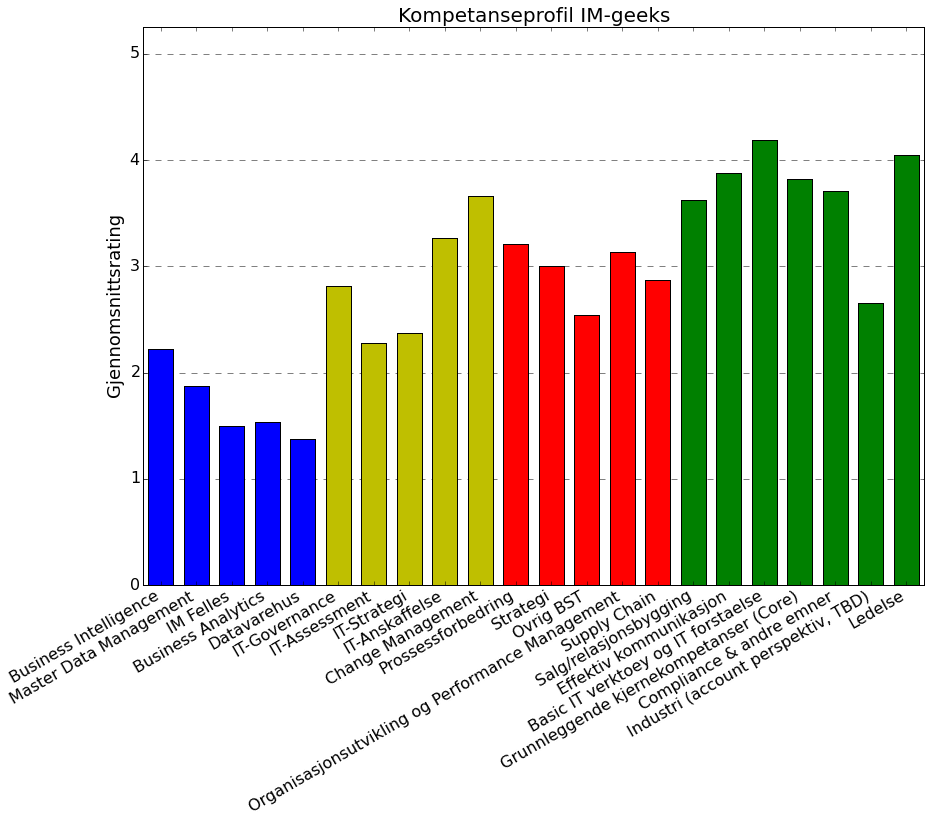

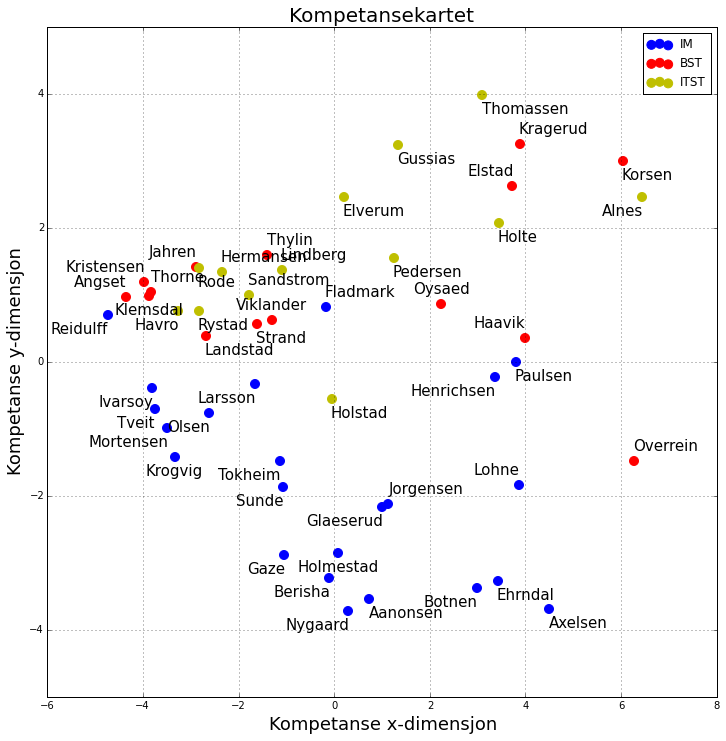

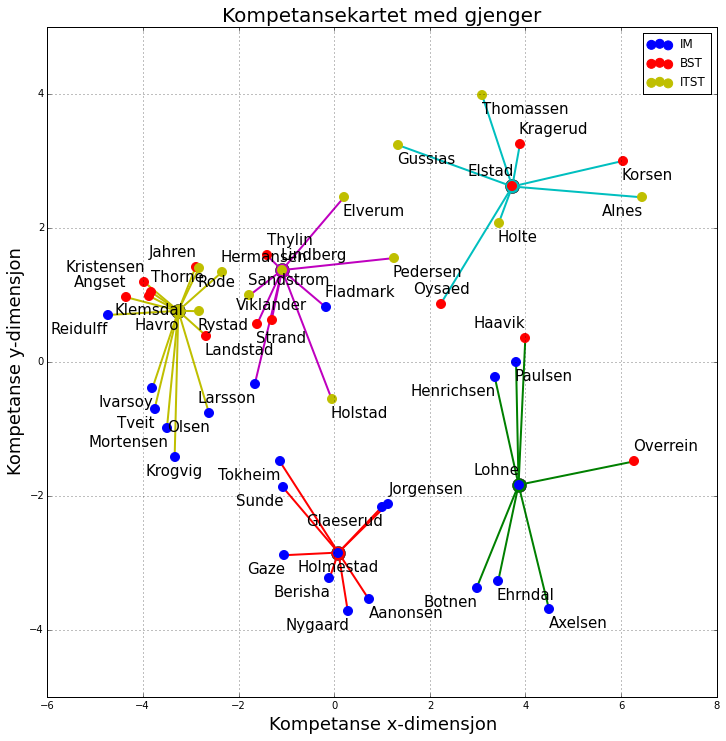

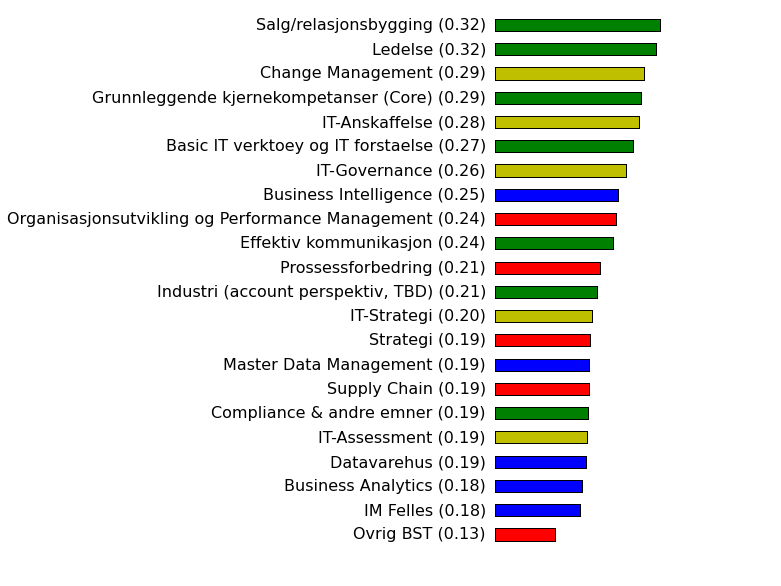

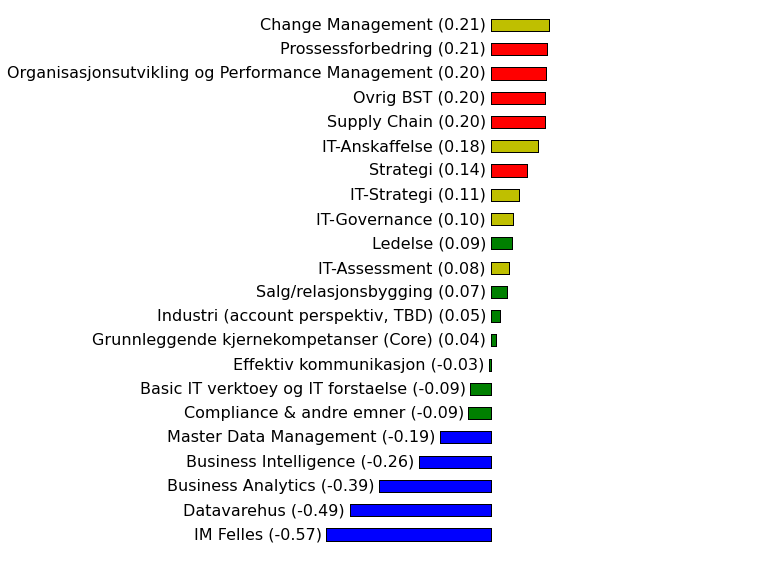

In [7]:
# Scatter plot
plot_transformed_point(ndf, cat, type)

plot_pca(newdf, lpos)
plot_cluster(newdf, cluster_df, lpos)

# Bar charts av komponenter
explain_axis(components, cat, subcat2cat, 1)
explain_axis(components, cat, subcat2cat, 2)


In [8]:
cluster_idx = 1
namelist = [tuple([a for a in ndf.reset_index().iloc[i][['Navn','Team']].values]) for i, l in enumerate(labels) if l==cluster_idx]
ndf.loc[namelist].mean(axis=0)
for n in namelist: print n

('Axelsen, Vebjorn', 'IM')
('Botnen, Martin', 'IM')
('Ehrndal, Marcus', 'IM')
('Henrichsen, Kristian', 'IM')
('Lohne, Erik', 'IM')
('Paulsen, Vegar', 'IM')
('Overrein, Erik', 'BST')
('Haavik, Ola', 'BST')
